# Preprocessing of EEG data

In this notebook, we will go through the basics of preprocessing EEG data using MNE. We will be using some sample data provided with the MNE package to do so. 

To preprocces the data following steps are performed
1. Load the data
2. Exclude bad channels
3. Common average reference
4. Filtering
5. Saving the data

After preprocessing the data is epoched for further analysis. This is done in the notebook [EEG_analysis.ipynb](EEG_analysis.ipynb)

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_ipynb_kernel.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load the sample data

To begin with we load the MNE sample data. It contains data from an experiment where checkerboard patterns were presented to the subject into the left and right visual (hemi)field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the smiley.

Looking at trials across modalities (auditory/visual) we can see the contrast between auditory and visual processing, while inspecting the left/right trials allows us to observe the contralateral visual processing of the brain (i.e. what is presented to the right visual hemifield is processed in the left visual cortex and vice versa).

Information about the sample data can be found [here](https://mne.tools/stable/documentation/datasets.html#sample-dataset) (the dataset is called sample).

In [2]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = []

raw.load_data()

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.30TB/s]
Untarring contents of '/home/ucloud/mne_data/MNE-sample-data-processed.tar.gz' to '/home/ucloud/mne_data'


Attempting to create new mne-python configuration file:
/home/ucloud/.mne/mne-python.json
Download complete in 01m35s (1576.2 MB)
Opening raw data file /home/ucloud/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG"
Bad channels,None
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


### Questions
Looking at the ouput from the load_data() function, answer the following questions:

**Q1:** How many EEG channels are there? **A:**

**Q2:** Were any EEG channels marked as bad during recording? **A:**

**Q3:** What is the sampling frequency? **A:**

**Q4:** How many minutes of data were recorded? **A:**

In [4]:
# Both EEG and MEG (grad and mag) were recorded, but we are only interested in working with the EEG data so we will select only the EEG channels + the stimulus channels which holds the triggers
raw.pick(['eeg', 'stim'])

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"9 Stimulus, 60 EEG"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


**Now lets try and plot the raw data!**

Using matplotlib as 2D backend.


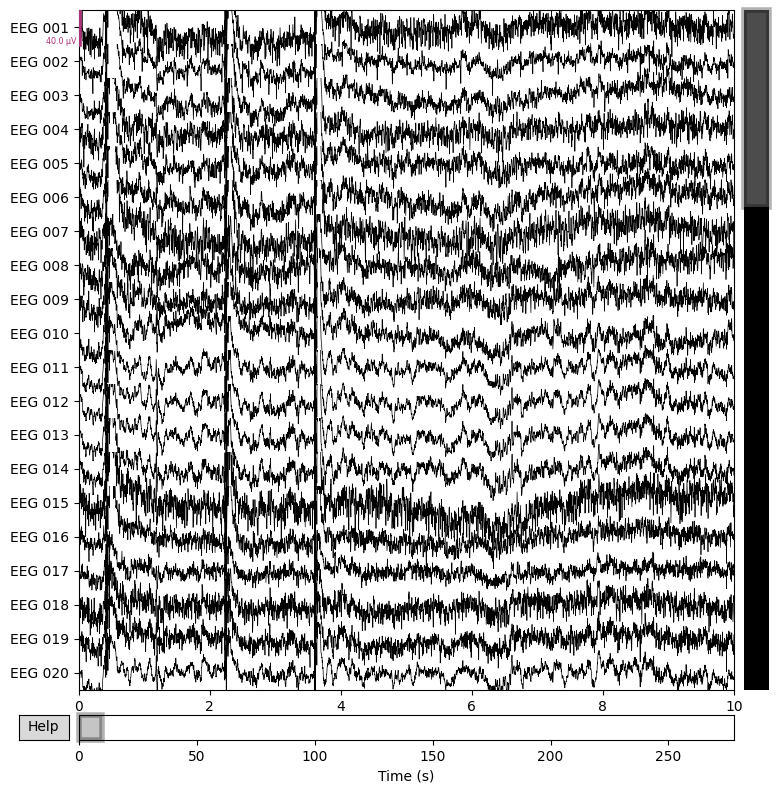

In [5]:
raw.plot();

Right now we are plotting using the default argument values of the plot() function. Try to play around with `Raw.plot()` method in order to:

**1. Plot all EEG channels simultaneously**

**2. Plot a full minute of the recording**

## 2. Exclude bad channels
When plotting all channels simultaneously, it is evident that one of the channels is not really picking up any signal (that is, it is flat). This is a bad channel and should be excluded from further analysis. There are other ways that channels might be bad, such as being too noisy, or picking up signals from other parts of the body. In this case, we will just exclude the channel that is flat.

**Begin by marking the channel as bad using the info attribute of the raw object. Then, plot the data again to see that the channel is now excluded.**

In [ ]:
raw.info["bads"] = [#insert channel here, #if there was another chacnnel you wanted to remove -insert it here]  

**After marking the channel as bad, we need to exclude it from the data. This is done using the pick() method of the raw object.**

Hint: set exclude='bads', but remember to keep the stim and the rest of the EEG channels!

## 3. Common average reference
The idea behind common average reference is to compute the average of the signal at all EEG electrodes and subtract it from the EEG signal at every electrode for every time point. To set this “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'. This is done after excluding bad channels, so the average is computed only over the good channels.

The rationale behind this is that the average of all the potentials recorded on the whole head due to current sources inside it is zero, this would make for a quiet or electrically neutral reference. However, in practice, to achieve such an ideal reference one would require large number of electrodes that cover the whole head uniformly, which is not the case in EEG recordings where limited number of electrodes cover mostly the upper part of the head.

If you want to know more, this is a good [resource](https://pressrelease.brainproducts.com/referencing/#20).

<div class="alert alert-block alert-info">
<b> Note: </b> The data used here has already been referenced to the average of all channels, but this code will be needed when you analyse your own data!

In [ ]:
# common average reference
# raw.set_eeg_reference('average', projection=True)

# applying the reference
# raw.apply_proj()

# plot the data to check that it looks sensical
# raw.plot();

## 4. Filtering
Now let's filter the data. A high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while a low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts), with frequencies higher than the frequencies of the signal we are interested in.


**Apply a high-pass filter at 0.1 Hz and a low-pass filter at 40 Hz, following the typical practises of EEG preprocessing.**


*Hint: The `Raw` class has a `filter()` method that can be used to filter the data*

**Plot the data to inspect the effect of the filtering**

### Question
**Q5:** If you compare the raw data with the filtered data, what differences do you see? **A:**


## 5. Saving the preprocessed data

In [7]:
import os

output_path = os.path.join(os.getcwd(), "preprocessed_data")

# make sure output path exists 
if not os.path.exists(output_path):
    os.mkdir(output_path)

# save the data
raw.save(os.path.join(output_path, 'preprocessed_data.fif'), overwrite=True)

Overwriting existing file.
Writing /work/LauraBockPaulsen#1941/CogNeuro24/EEG/day1/preprocessed_data/preprocessed_data.fif
Closing /work/LauraBockPaulsen#1941/CogNeuro24/EEG/day1/preprocessed_data/preprocessed_data.fif
[done]


/tmp/ipykernel_11965/2398933165.py:10: RuntimeWarning: This filename (/work/LauraBockPaulsen#1941/CogNeuro24/EEG/day1/preprocessed_data/preprocessed_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(os.path.join(output_path, 'preprocessed_data.fif'), overwrite=True)


# Optional exercise: Independent Component Analysis (ICA)


<dix class="alert alert-block alert-info">
This is an optional exercise. Make sure to go through the EEG analysis notebook before you do this exercise, and then come back to this one if you have time left.


ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

In [ ]:
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)

Here is some quick preprocessing code of the raw data to get you started. Just run the chunk below and read the comments. 

In [ ]:
# reading the file & loading in the data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file) # raw is an MNE object that contains the data of the class Raw
raw.info['bads'] = []
raw.load_data()

# pick only EEG
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])

# bad channels
raw.info['bads'] = ['EEG 053']

# common average
raw.set_eeg_reference(ref_channels='average', ch_type='eeg')


# high-pass 
# ICA is sensitive to slow drifts, therefore we are here using a high high-pass filter! 
# Note however, that when applying the ICA, we will do it to data high-pass filtered at 0.1 Hz
# See https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA
raw_fit = raw.copy().filter(1, None)

# low-pass 
raw_fit = raw_fit.filter(None, 40)

# high and low-pass filtering for the data not used to fit the ICA
raw = raw.filter(0.1, None)

# low-pass 
raw = raw.filter(None, 40)

**Set up and fit ICA with mne.preprocessing.ICA() with 800 iterations with a random seed at 7 (for reproducibility) and n_components=0.95**

n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data

**Plot the ICA components**

*Hint: ica.plot_components*

**Plot the time courses of the ICA components**

*Hint: ica.plot_sources*

### Questions
**Q:** Which components do you suspect to be noise? (*hint: look at the topographies of the components and the time courses of the components*) **A:**

**When you have identified them, show them to Laura!**

**Exclude the eye components and apply ica to the data**

**Plot the data after filtering and using ICA to reject artefacts**

**Now like above epoch the data and downsample it. Then make the single-trial and evoked plots.**

### Question
**Q:** Compare your results with and without ICA - can you tell any differences between the two, just qualitatively speaking? **A:**